In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import random
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from model import MLP, EarlyStopping, to_np
from plot import plot_scatter, plot_kde

In [3]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 13
plt.rcParams['figure.dpi'] = 200

In [4]:
# set random seed
rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
random.seed(rand_seed)

In [5]:
data = pd.read_csv('../data/cleaned_data.csv')
data.drop(columns=['S/N'], inplace=True)
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,150,3.5,1.00,14.05,118.7100,0.00,0.00,0.23,0.12,0.00,0.61
1,150,3.3,0.80,14.05,107.6772,0.20,0.00,0.23,0.07,0.00,0.66
2,150,3.2,0.50,14.05,91.1280,0.50,0.00,0.34,0.05,0.03,0.52
3,150,3.1,0.10,14.05,69.0624,0.90,0.01,0.42,0.05,0.02,0.42
4,150,3.0,0.05,14.05,66.3042,0.95,0.04,0.48,0.05,0.10,0.19


In [6]:
data.columns

Index(['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %', 'C2H4', 'CO', 'H2',
       'EtoH', 'FORM'],
      dtype='object')

In [7]:
# normalize the data to range [value/max, value/max]
feature_column = ['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %']
target_column = ['C2H4', 'EtoH', 'H2']
data[feature_column] = data[feature_column] / data[feature_column].max()
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,0.333333,0.744681,1.00,1.0,1.000000,0.00,0.00,0.23,0.12,0.00,0.61
1,0.333333,0.702128,0.80,1.0,0.907061,0.20,0.00,0.23,0.07,0.00,0.66
2,0.333333,0.680851,0.50,1.0,0.767652,0.50,0.00,0.34,0.05,0.03,0.52
3,0.333333,0.659574,0.10,1.0,0.581774,0.90,0.01,0.42,0.05,0.02,0.42
4,0.333333,0.638298,0.05,1.0,0.558539,0.95,0.04,0.48,0.05,0.10,0.19


In [8]:
num_points = data.shape[0]
X = torch.from_numpy(data[feature_column].values).float()
y = torch.from_numpy(data[target_column].values).float()
print(X.shape, y.shape)

torch.Size([35, 6]) torch.Size([35, 3])


In [9]:
# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

In [10]:
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(np.array([6, 20, 20, 15, 3])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
loss_fn = nn.MSELoss(reduction ='mean')
steps = 10000
record_onn_loss = []
record_onn_loss_test = []
for i in range(steps):
  # zero gradients
  optimizer.zero_grad()
  # forward pass
  output = model(X_train)
  # calculate loss
  loss = loss_fn(output, y_train)
  loss.backward()
  optimizer.step()
  if i % 100 == 0:
    record_onn_loss.append(loss.item())

  # early stopping
  avg_loss = np.mean(record_onn_loss)
  with torch.no_grad():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)
    if i % 100 == 0:
      record_onn_loss_test.append(test_loss.item())
    print(f'Train Loss {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')


Train Loss 0.250, Test Loss: 0.228
Train Loss 0.248, Test Loss: 0.226
Train Loss 0.247, Test Loss: 0.225
Train Loss 0.245, Test Loss: 0.224
Train Loss 0.244, Test Loss: 0.222
Train Loss 0.242, Test Loss: 0.221
Train Loss 0.241, Test Loss: 0.219
Train Loss 0.240, Test Loss: 0.218
Train Loss 0.238, Test Loss: 0.217
Train Loss 0.237, Test Loss: 0.215
Train Loss 0.235, Test Loss: 0.214
Train Loss 0.234, Test Loss: 0.212
Train Loss 0.232, Test Loss: 0.211
Train Loss 0.231, Test Loss: 0.210
Train Loss 0.230, Test Loss: 0.208
Train Loss 0.228, Test Loss: 0.207
Train Loss 0.227, Test Loss: 0.206
Train Loss 0.225, Test Loss: 0.205
Train Loss 0.224, Test Loss: 0.203
Train Loss 0.223, Test Loss: 0.202
Train Loss 0.221, Test Loss: 0.201
Train Loss 0.220, Test Loss: 0.199
Train Loss 0.219, Test Loss: 0.198
Train Loss 0.217, Test Loss: 0.197
Train Loss 0.216, Test Loss: 0.196
Train Loss 0.215, Test Loss: 0.194
Train Loss 0.214, Test Loss: 0.193
Train Loss 0.212, Test Loss: 0.192
Train Loss 0.211, Te

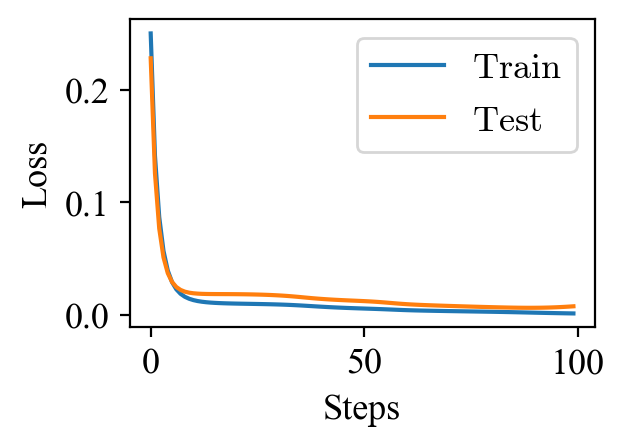

In [11]:
plt.figure(figsize=(3, 2))
plt.plot(record_onn_loss, label=r'$\rm Train $')
plt.plot(record_onn_loss_test, label=r'$\rm Test $')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.legend()

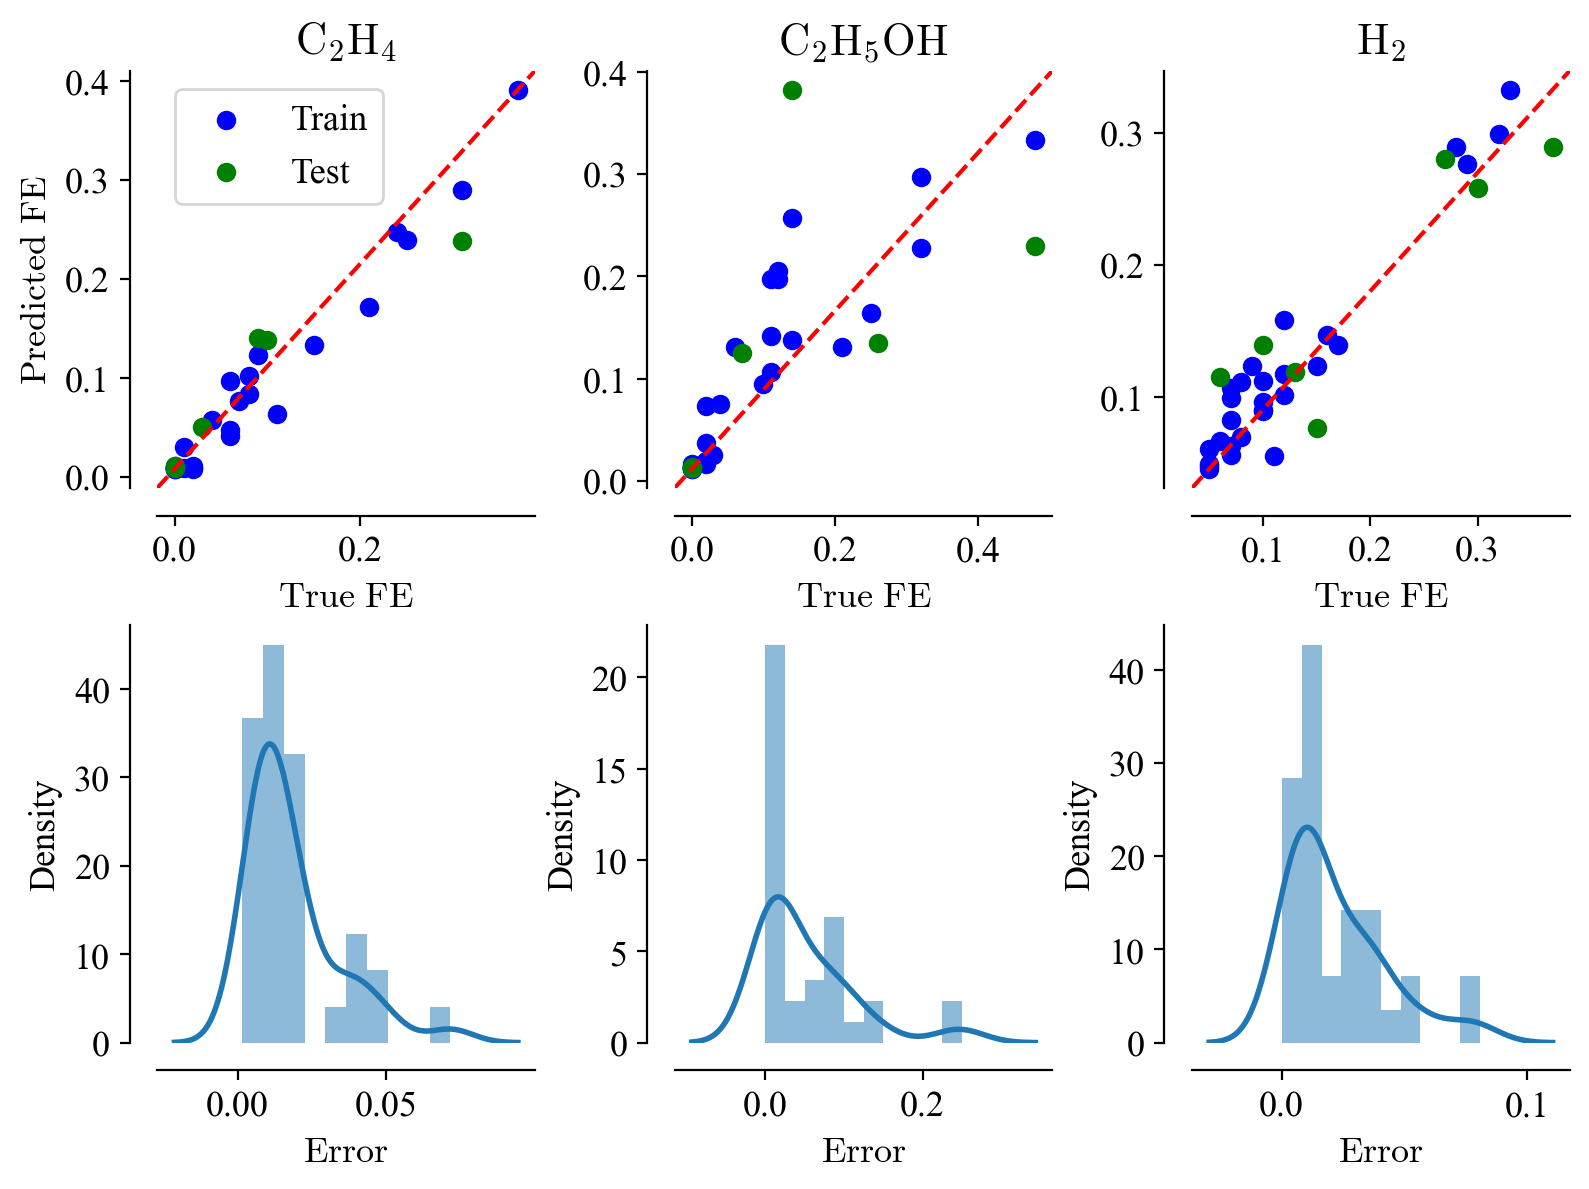

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
plot_target_column = [r'$\rm C_2H_4$', r'$\rm C_2H_5OH$', r'$\rm H_2$']
output_test = model(X_test) # predict the test data


df = {
        'y_train': y_train, 'y_test': y_test, 
        'output_train': output, 'output_test': output_test
        }
# Plot scatter plots
for col in range(3):
    plot_scatter(ax=ax, data=df, row=0, col=col, column_names=plot_target_column)

# Plot KDE plots
for col in range(3):
    plot_kde(ax=ax, data=df, row=1, col=col)

plt.tight_layout()
sns.despine(fig=fig, offset=10)
plt.show()


In [13]:
# save model
torch.save(model.state_dict(), './neural_network_model.pth')